# Credit Card Fraud Detection with Machine Learning Models
## Model Training
### Ian Heung

In the previous notebook, we made 5 different training datasets that feature various sampling methods to mitigate the effects of the class imbalance in the original dataset. We will now train the training data on various models and evaluate which sampling method will create a model that yields the best results on our testing data.

## Setting up Models

We will choose 4 model types: 

- Decision Trees
- KNNs (K-Nearest Neighbors)
- Logistic Regression
- Support Vector Machines

Below are some of the Pros and Cons for each model type:

| Model | Pros | Cons |
|-|-|-|
| **Decision Trees** | - Handles non-linearity <br> - Provides insight into feature importance | - Prone to overfitting <br> - Bias towards features with more levels <br> - Instability with small changes in data |
| **K-Nearest Neighbors (KNN)** | - Simple methodology <br>  - Flexible with distance metrics | - Computationally intensive <br> - Sensitive to noise |
| **Logistic Regression** | - Ideal for binary classification <br>  - Regularization available | - Assumes linear decision boundary <br> - Not ideal for large feature sets |
| **Support Vector Machines (SVM)** | - Effective in high-dimensional spaces <br> - Versatile kernels for non-linearity <br> - Robust to overfitting | - Computationally expensive <br> - Hyperparameter selection and tuning can be challenging|

In addition to each of the model types, a grid search for hyperparamter tuning will be performed each fitting where possible. Since we are testing all the differently sampled datasets on each model type, we need to be aware of the dataset size, since there are some models that will be less effective due to computational costs.

In [1]:
# imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,roc_curve, classification_report, confusion_matrix 

import warnings
warnings.filterwarnings("ignore")

I chose to make a custom scorer, because in a scenario where we want to identify as many fraudulent cases as possible, we want to prioritize minimizing false negatives. Below is a confusion matrix that is an example case that shows a sample model that predicts whether transactions are fraudulent. 

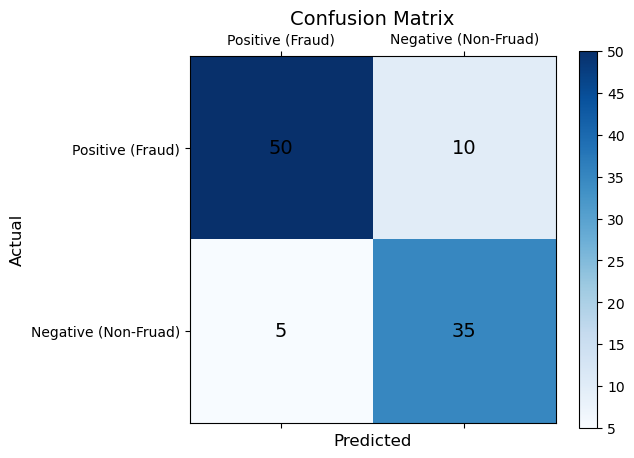

In [29]:
example_matrix = np.array([[50, 10],  # True Positives, False Negative
                             [5, 35]])  # False Positive, True Negative

fig, ax = plt.subplots()

cax = ax.matshow(example_matrix, cmap='Blues')

plt.colorbar(cax)

for (i, j), value in np.ndenumerate(example_matrix):
    ax.text(j, i, f'{value}', ha='center', va='center', color='black', fontsize=14)

ax.set_xlabel('Predicted', fontsize=12)
ax.set_ylabel('Actual', fontsize=12)

ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(['Positive (Fraud)', 'Negative (Non-Fruad)'])
ax.set_yticklabels(['Positive (Fraud)', 'Negative (Non-Fruad)'])

plt.title('Confusion Matrix', fontsize=14)
plt.tight_layout()

plt.show()


The model is good at detecting true positives (fraudulent cases). It might seem counterintuitive that fraudulent cases are considered positive, but because this is the class we particularly care about, it is labeled as the positive class. However, we see that there are 10 fraud cases incorrectly classified as non-fraud. This is concerning because it means the model failed to detect these fraudulent cases. Additionally, we observe that the model has classified 5 non-fraud cases as fraud. This outcome is preferable, as we would rather be more cautious and flag potential fraud cases, even if there is no actual fraud. In this situation, we prefer to have more false positives, non-fraud cases classified as fraud, while minimizing false negatives, where fraud cases are classified as non-fraud.

Lets load in our training data for all 5 sampling cases. If we recall, these were the sampling cases each number corresponded to:

1. No Balancing at All
2. Undersampling
3. Oversampling
4. Undersampling + Oversampling
5. Undersampling + Oversampling + Outlier Removal

In [17]:
# data directory
directory = 'data'

# 1 - unsampled data
xtrain_1 = pd.read_csv(os.path.join(directory, 'xtrain.csv'))
ytrain_1 = pd.read_csv(os.path.join(directory, 'ytrain.csv'))

# convert 
xtrain_1 = xtrain_1.values
ytrain_1 = ytrain_1.values

# 2 - undersampled data
xtrain_2 = pd.read_csv(os.path.join(directory, 'xtrain_undersampled.csv'))
ytrain_2 = pd.read_csv(os.path.join(directory, 'ytrain_undersampled.csv'))

xtrain_2 = xtrain_2.values
ytrain_2 = ytrain_2.values

# 3 - oversampled data
xtrain_3 = pd.read_csv(os.path.join(directory, 'xtrain_oversampled.csv'))
ytrain_3 = pd.read_csv(os.path.join(directory, 'ytrain_oversampled.csv'))

xtrain_3 = xtrain_3.values
ytrain_3 = ytrain_3.values

# 4 - mix sampled data
mixed_sampling_filenames = np.load(os.path.join(directory, 'mixed_sampling_filenames.npy')) # for parsing filenames of case 4 and 5
xtrain_4 = []
ytrain_4 = []

for n in mixed_sampling_filenames:
    x = pd.read_csv(os.path.join(directory, f'xtrain_mix_{n}.csv'))
    y = pd.read_csv(os.path.join(directory, f'ytrain_mix_{n}.csv'))
    
    xtrain_4.append(x)
    ytrain_4.append(y)

# 5 - filtered mix sampled data
xtrain_5 = []
ytrain_5 = []

for n in mixed_sampling_filenames:
    x = pd.read_csv(os.path.join(directory, f'xtrain_mix_{n}.csv'))
    y = pd.read_csv(os.path.join(directory, f'ytrain_mix_{n}.csv'))
    
    xtrain_5.append(x)
    ytrain_5.append(y)
    
# test data
xtest = pd.read_csv(os.path.join(directory, 'xtest.csv'))
ytest = pd.read_csv(os.path.join(directory, 'ytest.csv'))

xtest = xtest.values
ytest = ytest.values

We will define our model training pipeline here. The range of the grid search terms have been determined through multiple training efforts. 

In [14]:
def train_models(xtrain, ytrain):
    # decision trees
    decision_trees = DecisionTreeClassifier()
    # kNN
    knn = KNeighborsClassifier()
    # logistic regression
    logistic = LogisticRegression()
    # support vector machines
    svm = SVC()

    # decision trees grid search hyperparameters
    dt_hyperparams = {
            "max_depth": [10, 20, 30],
            "criterion": ["gini", "entropy"],
            "max_leaf_nodes": [10, 20, 30]
        }

    # knn  trees grid search hyperparameters
    min_n = 2
    max_n = 20
    # number of neighbours array
    n_array = np.arange(min_n, max_n,5)

    knn_hyperparams = {
        'n_neighbors': n_array,
        'weights': ['uniform', 'distance']
        }

    # logistic regression hyperparameters
    logistic_hyperparams = {
        "penalty": ['l1', 'l2'], 
        'C': [0.01, 0.1, 1, 10]
        }

    # support vector machines hyperparameters
    svm_hyperparams = {
        'C': [0.01, 0.1, 1, 10], 
        'kernel': ['rbf', 'poly', 'sigmoid', 'linear']
        }

    models = [('Decision Trees', decision_trees, dt_hyperparams), 
            ('KNN', knn, knn_hyperparams), 
            ('Logistic Regression', logistic, logistic_hyperparams),
            ('Support Vector Machines', svm, svm_hyperparams)]

    results = {}
    
    precision_true_neg = make_scorer(f1_score) #make_scorer(precision_score, pos_label=1)

    for name, model, grid in models:
        clf = GridSearchCV(
            estimator=model, 
            param_grid=grid,
            scoring= precision_true_neg, 
            cv=5,  
            verbose=3, 
            n_jobs=-1
        )
        
        print("Training", name, "Model")                    
        classifier = clf.fit(xtrain, ytrain)
        print("Validation fitting with best F1 score:", clf.best_score_)
        print("Best parameters found from grid search: ", clf.best_params_)
        print()
        
        # save to dictionary
        results[name] = [classifier.best_estimator_, clf.best_score_, clf.best_params_]
        
    return results

Lets train our models on the different sampling training sets.

In [15]:
results_1 = train_models(xtrain_1, ytrain_1)

Training Decision Trees Model
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Validation fitting with best F1 score: 0.832142807335595
Best parameters found from grid search:  {'criterion': 'gini', 'max_depth': 20, 'max_leaf_nodes': 25}
Training KNN Model
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Validation fitting with best F1 score: 0.831949398234783
Best parameters found from grid search:  {'n_neighbors': 14, 'weights': 'distance'}
Training Logistic Regression Model
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Validation fitting with best F1 score: 0.7269477034508885
Best parameters found from grid search:  {'C': 1, 'penalty': 'l2'}
Training Support Vector Machines Model
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Validation fitting with best F1 score: 0.8158213217605
Best parameters found from grid search:  {'C': 1, 'kernel': 'poly'}


In [18]:
results_2 = train_models(xtrain_2, ytrain_2)

Training Decision Trees Model
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Validation fitting with best F1 score: 0.9054088359728052
Best parameters found from grid search:  {'criterion': 'entropy', 'max_depth': 20, 'max_leaf_nodes': 50}
Training KNN Model
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Validation fitting with best F1 score: 0.9314202000665835
Best parameters found from grid search:  {'n_neighbors': 2, 'weights': 'distance'}
Training Logistic Regression Model
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Validation fitting with best F1 score: 0.9330222294178367
Best parameters found from grid search:  {'C': 10, 'penalty': 'l2'}
Training Support Vector Machines Model
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Validation fitting with best F1 score: 0.931094429285662
Best parameters found from grid search:  {'C': 1, 'kernel': 'linear'}


In [19]:
results_3 = train_models(xtrain_3, ytrain_3)

Training Decision Trees Model
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Validation fitting with best F1 score: 0.9820372565620348
Best parameters found from grid search:  {'criterion': 'gini', 'max_depth': 20, 'max_leaf_nodes': 75}
Training KNN Model
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Validation fitting with best F1 score: 0.9996176471811149
Best parameters found from grid search:  {'n_neighbors': 2, 'weights': 'uniform'}
Training Logistic Regression Model
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Validation fitting with best F1 score: 0.9437230766858414
Best parameters found from grid search:  {'C': 10, 'penalty': 'l2'}
Training Support Vector Machines Model
Fitting 5 folds for each of 12 candidates, totalling 60 fits


In [ ]:
results_4 = []
for i in range(len(xtrain_4)):
    result = train_models(xtrain_4[i], ytrain_4[i])
    results_4.append(result)

In [ ]:
results_5 = []
for i in range(len(xtrain_5)):
    result = train_models(xtrain_5[i], ytrain_5[i])
    results_5.append(result)

In [ ]:
def print_results(results):
    for k in results.keys():
        print("Model: ", k)
        print("Best Score: ", results[k][1])
        print("Best Parameters: ", results[k][2])
        print()

In [72]:
# with outliers in dataset
ypred_dt_outliers = dt_model_outliers.best_estimator_.predict(xtest)
ypred_knn_outliers = knn_model_outliers.best_estimator_.predict(xtest)
ypred_logistic_outliers = logistic_model_outliers.best_estimator_.predict(xtest)
ypred_svm_outliers = svm_model_outliers.best_estimator_.predict(xtest)

# without outliers in dataset
ypred_dt_filtered = dt_model_filtered.best_estimator_.predict(xtest)
ypred_knn_filtered = knn_model_filtered.best_estimator_.predict(xtest)
ypred_logistic_filtered = logistic_model_filtered.best_estimator_.predict(xtest)
ypred_svm_filtered = svm_model_filtered.best_estimator_.predict(xtest)

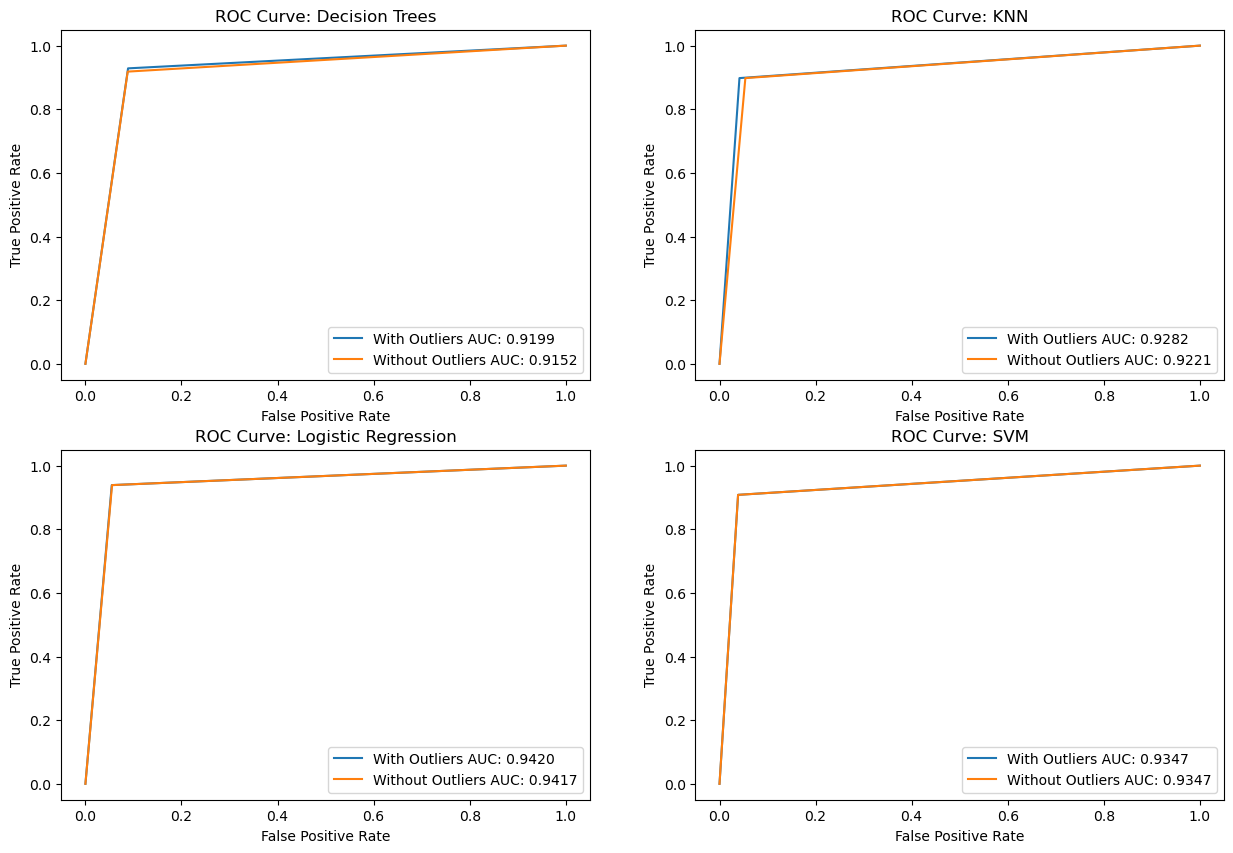

In [73]:
# ROC plotting
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

fpr_outlier_1, tpr_outlier_1, _ = roc_curve(ytest, ypred_dt_outliers)
fpr_filtered_1, tpr_filtered_1, _ = roc_curve(ytest, ypred_dt_filtered) 

ax1 = axes[0][0]
ax1.plot(fpr_outlier_1, tpr_outlier_1, label='With Outliers AUC: {:.4f}'.format(roc_auc_score(ytest, ypred_dt_outliers)))
ax1.plot(fpr_filtered_1, tpr_filtered_1, label='Without Outliers AUC: {:.4f}'.format(roc_auc_score(ytest, ypred_dt_filtered)))
ax1.set_title('ROC Curve: Decision Trees')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.legend(loc='lower right', fontsize=10)

fpr_outlier_2, tpr_outlier_2, _ = roc_curve(ytest, ypred_knn_outliers)
fpr_filtered_2, tpr_filtered_2, _ = roc_curve(ytest, ypred_knn_filtered) 

ax2 = axes[0][1]
ax2.plot(fpr_outlier_2, tpr_outlier_2, label='With Outliers AUC: {:.4f}'.format(roc_auc_score(ytest, ypred_knn_outliers)))
ax2.plot(fpr_filtered_2, tpr_filtered_2, label='Without Outliers AUC: {:.4f}'.format(roc_auc_score(ytest, ypred_knn_filtered)))
ax2.set_title('ROC Curve: KNN')
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.legend(loc='lower right', fontsize=10)

fpr_outlier_3, tpr_outlier_3, _ = roc_curve(ytest, ypred_logistic_outliers)
fpr_filtered_3, tpr_filtered_3, _ = roc_curve(ytest, ypred_logistic_filtered) 

ax3 = axes[1][0]
ax3.plot(fpr_outlier_3, tpr_outlier_3, label='With Outliers AUC: {:.4f}'.format(roc_auc_score(ytest, ypred_logistic_outliers)))
ax3.plot(fpr_filtered_3, tpr_filtered_3, label='Without Outliers AUC: {:.4f}'.format(roc_auc_score(ytest, ypred_logistic_filtered)))
ax3.set_title('ROC Curve: Logistic Regression')
ax3.set_xlabel('False Positive Rate')
ax3.set_ylabel('True Positive Rate')
ax3.legend(loc='lower right', fontsize=10)

fpr_outlier_4, tpr_outlier_4, _ = roc_curve(ytest, ypred_svm_outliers)
fpr_filtered_4, tpr_filtered_4, _ = roc_curve(ytest, ypred_svm_filtered) 

ax3 = axes[1][1]
ax3.plot(fpr_outlier_4, tpr_outlier_4, label='With Outliers AUC: {:.4f}'.format(roc_auc_score(ytest, ypred_svm_outliers)))
ax3.plot(fpr_filtered_4, tpr_filtered_4, label='Without Outliers AUC: {:.4f}'.format(roc_auc_score(ytest, ypred_svm_filtered)))
ax3.set_title('ROC Curve: SVM')
ax3.set_xlabel('False Positive Rate')
ax3.set_ylabel('True Positive Rate')
ax3.legend(loc='lower right', fontsize=10)

plt.show()